In [2]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
np.random.seed = 42
import torch
import cv2
from create_dataset import *
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
'''
    This cell is required since I've messed around with pickle module while serializing data. Sorry for that.
'''
import sys, types
sys.modules['dataset'] = types.ModuleType('dataset')
sys.modules['dataset.map_sample'] = types.ModuleType('map_sample')
sys.modules['dataset.map_sample'].__dict__['MapSample'] = MapSample

c:\Users\meiri\miniconda3\envs\CogRobProj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
map_dataset = torch.load(r'C:\Users\meiri\OneDrive - Technion\Desktop\5th semester\CogRobProject\maps_dataset.pt')


train_size = int(0.8 * len(map_dataset))
test_size = len(map_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(map_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=True, collate_fn=custom_collate_fn)

In [4]:
def vis_grid(grid):
    plt.figure(figsize=(5,5))
    g = sns.heatmap(grid, annot=False, fmt=".2f", cmap="magma", cbar=True, square=True)
    g.tick_params(left=False, bottom=False)
    g.set(xticklabels=[], yticklabels=[])
    plt.show()

# ML Model

21-3-2.0

In [5]:
# import torch.nn as nn   
# from torch.nn import Conv2d, ReLU, Module, ModuleList

# class Block(Module):
#     def __init__(self, inChannels, outChannels):
#         super().__init__()
#         self.conv1 = Conv2d(inChannels, outChannels, kernel_size=3, stride=1, dilation=1, padding=1)
#         self.relu = ReLU()
#         self.batchnorm = nn.BatchNorm2d(outChannels)
#         self.pool = nn.MaxPool2d(2)

#     def forward(self, x):
#         return self.pool(self.batchnorm(self.relu(self.conv1(x))))

# class distancer(nn.Module):
#     def __init__(self):
#         super(distancer, self).__init__()

#         self.first_layer = Block(2, 32)
#         self.mid_conv_layers = []
#         for i in range(1):
#             self.mid_conv_layers.append(Block(32, 32))
        
#         self.last_layer = Block(32, 1)
#         self.mid_conv_layers = ModuleList(self.mid_conv_layers)
#         self.fc = nn.Sequential(nn.Linear(12*12, 50*50), nn.ReLU(), nn.Linear(50*50, 100*100), nn.ReLU())

#     def forward(self, x):
#         x = self.first_layer(x)
#         for layer in self.mid_conv_layers:
#             x = layer(x)
        
#         x = self.last_layer(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.fc(x)
#         x = x.reshape(x.shape[0], 1, 100, 100)
#         return x

25-3

In [6]:
import torch.nn as nn   
from torch.nn import Conv2d, ReLU, Module, ModuleList

class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = Conv2d(inChannels, outChannels, kernel_size=3, stride=1, dilation=1, padding=1)
        self.relu = ReLU()
        self.batchnorm = nn.BatchNorm2d(outChannels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        return self.pool(self.batchnorm(self.relu(self.conv1(x))))

class distancer(nn.Module):
    def __init__(self):
        super(distancer, self).__init__()

        self.first_layer = Block(2, 64)
        self.mid_conv_layers = []
        for i in range(1):
            self.mid_conv_layers.append(Block(64, 64))
        
        self.last_layer = Block(64, 16)
        self.mid_conv_layers = ModuleList(self.mid_conv_layers)
        self.fc = nn.Sequential(nn.Linear(12*12*16, 50*100), nn.ReLU(), nn.Linear(100*50, 100*100), nn.ReLU())

    def forward(self, x):
        x = self.first_layer(x)
        for layer in self.mid_conv_layers:
            x = layer(x)
        
        x = self.last_layer(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = x.reshape(x.shape[0], 1, 100, 100)
        return x

In [7]:
model = distancer()
model.load_state_dict(torch.load(r'C:\Users\meiri\OneDrive - Technion\Desktop\5th semester\CogRobProject\code\25-3-model.pkl', map_location=torch.device('cpu')))
model.eval()

distancer(
  (first_layer): Block(
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (last_layer): Block(
    (conv1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mid_conv_layers): ModuleList(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Sequential(
  

# Creating environment

In [8]:
def ground_truth_dist(grid_original, goal_val): # Goal could be a tuple of the goal coordinates of a unique value for the goal location
    G = nx.Graph()
    if type(grid_original) == torch.Tensor:
        grid = grid_original.detach().clone().tolist()
    else:
        grid = grid_original.copy()

    obstacle_val = 1
    goal_tile = None
    
    if type(grid) == np.ndarray:
        # print(grid.shape)
        m = grid.shape[0]
        n = grid.shape[1]
    else:
        m = len(grid)
        n = len(grid[0])
    
    for i in range(m):
        for j in range(n):
            if grid[i][j] != obstacle_val:
                G.add_node((i,j))
                if i > 0 and grid[i-1][j] != obstacle_val:
                    G.add_edge((i,j), (i-1,j))
                if i < m-1 and grid[i+1][j] != obstacle_val:
                    G.add_edge((i,j), (i+1,j))
                if j > 0 and grid[i][j-1] != obstacle_val:
                    G.add_edge((i,j), (i,j-1))
                if j < n-1 and grid[i][j+1] != obstacle_val:
                    G.add_edge((i,j), (i,j+1))
                if (i, j) == goal_val or grid[i][j] == goal_val:
                    goal_tile = (i,j)
    if goal_tile is None:
        raise Exception("No goal tile found")
    
    length, path = nx.single_source_dijkstra(G, goal_tile)
    
    grid = np.array([[length[(i,j)] if (i,j) in length.keys() else -1 for j in range(n)] for i in range(m)])
    
    if type(grid_original) == torch.Tensor:
        grid = torch.tensor(grid)
    return grid, G

(100, 100)
[45, 37]
[12, 98]


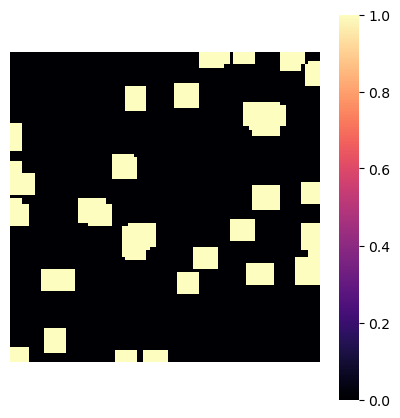

In [12]:
ex_map = None
ex_goal = None
ex_start = None

for maps, starts, goals, goals_tensors, dist_tensors, paths in test_loader:
    idx = 14
    ex_torch_map = maps[idx].clone().detach()
    ex_goals_tensor = goals_tensors[idx].clone().detach()
    ex_map = maps[idx].clone().detach().numpy().squeeze()
    ex_goal = goals[idx].tolist()
    ex_start = starts[idx].tolist()
    break

print(ex_map.shape)
print(ex_goal)
print(ex_start)
vis_grid(ex_map)

In [21]:
from collections import defaultdict
import random
import seaborn as sns
import colorcet as cc
import torch.nn.functional as F
from scipy.spatial import distance
import time
random.seed(69420)

def label_islands(grid_graph, goal_val, agent_val):
    island_labels = {}
    island_label = max([goal_val, agent_val])
    for node in grid_graph.nodes:
        if node not in island_labels:
            if grid_graph.nodes[node]['map_val'] == 1:
                island_label += 1
                island_labels[node] = island_label
                label_rooted_island(grid_graph, island_labels, node)
            else:
                island_labels[node] = 0
    return island_labels

def label_rooted_island(grid_graph, island_labels, root):
    island_label = island_labels[root]
    for neighbor in grid_graph.neighbors(root):
        if grid_graph.nodes[neighbor]['map_val'] == 1 and neighbor not in island_labels:
            island_labels[neighbor] = island_label
            label_rooted_island(grid_graph, island_labels, neighbor)
        else:
            continue

# Environment class that contains a grid of states encoded as a 2D array. The agent can move in 4 directions (up, down, left, right) and can fall into holes. The agent can also reach a goal state, which ends the episode
class Environment:
    def __init__(self, input_map: np.ndarray, start: list, goal: list, torch_map: torch.Tensor, goal_tensor: torch.Tensor, move_prob=0.2, use_model=False):
        self.map = input_map.copy()
        self.turn_num = 1
        self.start = start
        self.agent_loc = start # Agent location in grid - 1
        self.goal = goal # Gaol val in grid - 2
        self.torch_map = torch_map # 0 - free, 1 - obstacle
        self.goal_tensor = goal_tensor
        self.G = nx.grid_2d_graph(self.map.shape[0], self.map.shape[1])
        
        nx.set_node_attributes(self.G, {node: self.map[node[0]][node[1]] for node in self.G.nodes}, "map_val")
        # print(self.agent_loc, self.goal, type(self.agent_loc), type(self.goal))
        # Give one label for each obstacle
        island_labels = label_islands(self.G, 2, 1)
        self.labeled_grid = np.zeros(self.map.shape)
        
        for key, value in island_labels.items():
            self.labeled_grid[key[0]][key[1]] = value
        self.labeled_grid = self.labeled_grid.astype(int)
        
        self.labeled_grid[goal[0]][goal[1]] = 2 # Goal val in grid - 2
        self.labeled_grid[start[0]][start[1]] = 1 # Agent val in grid - 1
        
        
        # Create a list of tiles for each obstacle
        self.tiles_for_each_island = defaultdict(list)
        for key, val in sorted(island_labels.items()):
            if val == 0 or val == 2 or val == 1:
                continue
            self.tiles_for_each_island[val].append(key)
        
        # print(self.tiles_for_each_island)
        
        self.obst_sys = obstacle_system(self)
        
        self.exctract_dist_mat()
        
        # self.move_agent(self.exctract_dist_mat(use_model=True))
        # self.obst_sys.move_system()
        # self.turn_num += 1
        while (self.agent_loc[0] != self.goal[0] or self.agent_loc[1] != self.goal[1]) and self.turn_num < 250:
            # fig = plt.figure(figsize=(5,5))
            # n = np.max(self.labeled_grid+1)
            # # discrete colormap (n samples from a given cmap)
            # cmap = sns.color_palette("Pastel2", n)
            # palette = sns.color_palette(cc.glasbey_hv, n_colors=n)
            # ax = sns.heatmap(self.labeled_grid, cmap=palette, xticklabels=False, yticklabels=False)
            # plt.title('Simulation map: \n0 - free scace | 1 - agent | 2 - goal | other - obstacle', fontsize=8)

            # # modify colorbar:
            # colorbar = ax.collections[0].colorbar
            # r = colorbar.vmax - colorbar.vmin

            # plt.savefig(f'map_plots\state_{self.turn_num}.png')
            # plt.close()
            self.move_agent(self.exctract_dist_mat(use_model=use_model))
            self.obst_sys.move_system()
            self.turn_num += 1
            # print(self.turn_num)
            
        # print(self.turn_num)
    def exctract_dist_mat(self, use_model=False):
        map_copy = self.labeled_grid.copy()
        if not use_model:
            # make all values bigger than 1 to 1
            map_copy[map_copy > 1] = 1
            map_copy[self.goal[0]][self.goal[1]] = 2
            dist_grid, _ = ground_truth_dist(map_copy, 2)
            # vis_grid(dist_grid)
        else:
            map_copy = torch.tensor(map_copy)

            # make all non 0 values to 1
            map_copy[map_copy == 1] = 0
            map_copy[map_copy == 2] = 0
            map_copy[map_copy > 2] = 1
            map_copy = map_copy.unsqueeze(0)
            # vis_grid(map_copy.squeeze().tolist())
            X = torch.cat((map_copy, self.goal_tensor.unsqueeze(0)), dim=0)
            # print(X.shape)
            pred = model(X.unsqueeze(0)).squeeze(0).squeeze()
            
            # kernel = torch.ones((1, 1, 5, 5)) / 25.0
            # # apply convolution with the smoothing kernel
            # pred = F.conv2d(pred, kernel, padding=2).squeeze(0).squeeze()
            # pred[self.goal[0]][self.goal[1]] = 0
            
            # # Smooth values in each next tile
            # alx = self.agent_loc[0]
            # aly = self.agent_loc[1]
            
            # looking_dist = 5
            # if alx < self.labeled_grid.shape[0]-1:
            #     if len(pred[alx+1 : min([alx+looking_dist,self.labeled_grid.shape[0]-1]), aly].tolist()) > 0:
            #         pred[alx+1][aly] = np.min(pred[alx+1 : min([alx+looking_dist,self.labeled_grid.shape[0]-1]), aly].tolist())
            # if alx > 0:
            #     if len(pred[max([alx-looking_dist,0]):alx, aly].tolist()) > 0:
            #         pred[alx-1][aly] = np.min(pred[max([alx-looking_dist,0]):alx, aly].tolist())
            # if aly < self.labeled_grid.shape[1]-1:
            #     if len(pred[alx, aly+1 : min([aly+looking_dist,self.labeled_grid.shape[1]-1])].tolist()) > 0:
            #         pred[alx][aly+1] = np.min(pred[alx, aly+1 : min([aly+looking_dist,self.labeled_grid.shape[1]-1])].tolist())
            # if aly > 0:
            #     if len(pred[alx, max([aly-looking_dist,0]):aly].tolist()) > 0:
            #         pred[alx][aly-1] = np.min(pred[alx, max([aly-looking_dist,0]):aly].tolist())
                
            
            mask = map_copy.clone().squeeze() * -2 + torch.ones(self.torch_map.squeeze().shape)
            pred = torch.mul(pred, mask)
            # Make all values smaller than 0 to -1
            pred[pred < 0] = -1
            dist_grid = pred.tolist()
            # dist_grid = [[round(x) for x in myList] for myList in dist_grid]
            # vis_grid(dist_grid)
            dist_grid[self.goal[0]][self.goal[1]] = 0
            # vis_grid(dist_grid)
            
            
            # # L2 hueristic distance
            # pred = np.zeros((self.labeled_grid.shape[0], self.labeled_grid.shape[1]))
            # alx = self.agent_loc[0]
            # aly = self.agent_loc[1]
            
            # if alx < self.labeled_grid.shape[0]-1:
            #     pred[alx+1][aly] = distance.euclidean((alx+1, aly), tuple(self.goal))
            # if alx > 0:
            #     pred[alx-1][aly] = distance.euclidean((alx-1, aly), tuple(self.goal))
            # if aly < self.labeled_grid.shape[1]-1:
            #     pred[alx][aly+1] = distance.euclidean((alx, aly+1), tuple(self.goal))
            # if aly > 0:
            #     pred[alx][aly-1] = distance.euclidean((alx, aly-1), tuple(self.goal))
            # dist_grid = pred.tolist()
        return dist_grid
        
    
    def move_agent(self, dist_mat):
        locx = self.agent_loc[0]
        locy = self.agent_loc[1]
        
        possible_dirs = []
        closest_dist = np.inf
        closest_dir = None
        # (1, 0)
        if locx + 1 < self.labeled_grid.shape[0] and self.labeled_grid[locx + 1][locy] in [0,2] and dist_mat[locx + 1][locy] <= closest_dist:
            if dist_mat[locx + 1][locy] == closest_dist:
                indicator = random.random()
                if indicator < 0.5:
                    closest_dist = dist_mat[locx + 1][locy]
                    closest_dir = (1, 0)
                    possible_dirs.append((1, 0))
            else:
                closest_dist = dist_mat[locx + 1][locy]
                closest_dir = (1, 0)
                possible_dirs.append((1, 0))
        
        # (-1, 0)
        if locx - 1 >= 0 and self.labeled_grid[locx - 1][locy] in [0,2] and dist_mat[locx - 1][locy] <= closest_dist:
            if dist_mat[locx - 1][locy] == closest_dist:
                indicator = random.random()
                if indicator < 0.5:
                    closest_dist = dist_mat[locx - 1][locy]
                    closest_dir = (-1, 0)
                    possible_dirs.append((-1, 0))
            else:
                closest_dist = dist_mat[locx - 1][locy]
                closest_dir = (-1, 0)
                possible_dirs.append((-1, 0))
        
        # (0, 1)
        if locy + 1 < self.labeled_grid.shape[1] and self.labeled_grid[locx][locy + 1] in [0,2] and dist_mat[locx][locy + 1] <= closest_dist:
            if dist_mat[locx][locy + 1] == closest_dist:
                indicator = random.random()
                if indicator < 0.5:
                    closest_dist = dist_mat[locx][locy + 1]
                    closest_dir = (0, 1)
                    possible_dirs.append((0, 1))
            else:
                closest_dist = dist_mat[locx][locy + 1]
                closest_dir = (0, 1)
                possible_dirs.append((0, 1))
        
        # (0, -1)
        if locy - 1 >= 0 and self.labeled_grid[locx][locy - 1] in [0,2] and dist_mat[locx][locy - 1] <= closest_dist:
            if dist_mat[locx][locy - 1] == closest_dist:
                indicator = random.random()
                if indicator < 0.5:
                    closest_dist = dist_mat[locx][locy - 1]
                    closest_dir = (0, -1)
                    possible_dirs.append((0, -1))
            else:
                closest_dist = dist_mat[locx][locy - 1]
                closest_dir = (0, -1)
                possible_dirs.append((0, -1))
        
        randomize_movement_prob = 0.1
        indicator = random.random()
        if indicator < randomize_movement_prob:
            closest_dir = random.choice(possible_dirs)
        
        self.labeled_grid[self.agent_loc[0]][self.agent_loc[1]] = 0 # Remove agent from current location
        self.agent_loc = (self.agent_loc[0] + closest_dir[0], self.agent_loc[1] + closest_dir[1]) # Move agent
        self.labeled_grid[self.agent_loc[0]][self.agent_loc[1]] = 1 # Add agent to new location
    
    @staticmethod 
    def vis_grid(grid):
        plt.figure(figsize=(5,5))
        g = sns.heatmap(grid, annot=False, fmt=".2f", cmap="magma", cbar=True, square=True)
        g.tick_params(left=False, bottom=False)
        g.set(xticklabels=[], yticklabels=[])
        plt.show()
        
        
class obstacle:
    def __init__(self, tiles: list, env: Environment, label):
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        self.env = env
        self.map = env.map
        self.tiles = set(tiles)
        self.label = label
        self.direction_counter = {d: 0 for d in directions}
        self.direction_in_a_row = {d: 0 for d in directions}
    
    def move(self, d):
        if d == (0, 0):
            return

        new_tiles = set()
        for tile in self.tiles.copy():
            self.env.labeled_grid[tile[0]][tile[1]] = 0
            new_tiles.add((tile[0]+d[0], tile[1]+d[1]))
            self.tiles.remove(tile)
        
        for new_tile in new_tiles:
            self.env.labeled_grid[new_tile[0]][new_tile[1]] = self.label
        self.tiles = new_tiles
            
    
    def find_direction(self, input_map):
        p_sort = 0.5
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        rows_in_tiles = set([x for x, y in self.tiles])
        cols_in_tiles = set([y for x, y in self.tiles])
        
        uppest_tiles = [min([(r,c) for r, c in self.tiles if c==col], key=lambda x: x[0]) for col in cols_in_tiles]
        lowest_tiles = [max([(r,c) for r, c in self.tiles if c==col], key=lambda x: x[0]) for col in cols_in_tiles]
        leftest_tiles = [min([(r,c) for r, c in self.tiles if r==row], key=lambda x: x[1]) for row in rows_in_tiles]
        rightest_tiles = [max([(r,c) for r, c in self.tiles if r==row], key=lambda x: x[1]) for row in rows_in_tiles]
        
        order_rule = lambda d: self.direction_in_a_row[d] + 8*np.sqrt(np.log(self.env.turn_num+1) / (self.direction_counter[d]+1))
        # order_rule = lambda d: self.direction_in_a_row[d]
        
        indicator = np.random.rand()
        if indicator < p_sort:
            directions.sort(key=order_rule, reverse=True)
        else:
            random.shuffle(directions)
        
        while len(directions) > 0:
            d = directions.pop()
            if d == (-1, 0): # move up
                if False not in [tile[0]-1 >= 0 
                                 and (tile[0]-2 < 0 or (input_map[tile[0]-2][tile[1]] == 0 and input_map[tile[0]-1][tile[1]]==0)) for tile in uppest_tiles]:
                    if False not in [input_map[tile[0]-1][tile[1]] not in [1,2] and (tile[0]-2 < 0 or (input_map[tile[0]-2][tile[1]] not in [1,2])) for tile in self.tiles]:
                        self.direction_counter[d] += 1
                        self.direction_in_a_row = {d1: 0 if d1 != d else times+1 for d1, times in self.direction_in_a_row.items()}
                        return d
            elif d == (1, 0):
                if False not in [tile[0]+1 < self.env.map.shape[0]
                                 and (tile[0]+2 >= self.env.map.shape[0] or (input_map[tile[0]+2][tile[1]] == 0 and input_map[tile[0]+1][tile[1]]==0)) for tile in lowest_tiles]:
                    if False not in [input_map[tile[0]+1][tile[1]] not in [1,2] and (tile[0]+2 >= self.env.map.shape[0] or (input_map[tile[0]+2][tile[1]] not in [1,2])) for tile in self.tiles]:
                        self.direction_counter[d] += 1
                        self.direction_in_a_row = {d1: 0 if d1 != d else times+1 for d1, times in self.direction_in_a_row.items()}
                        return d
            elif d == (0, -1):
                if False not in [tile[1]-1 >= 0
                                 and (tile[1]-2 < 0 or (input_map[tile[0]][tile[1]-2] == 0 and input_map[tile[0]][tile[1]-1]==0)) for tile in leftest_tiles]:
                    if False not in [input_map[tile[0]][tile[1]-1] not in [1,2] and (tile[1]-2 < 0 or (input_map[tile[0]][tile[1]-2] not in [1,2])) for tile in self.tiles]:
                        self.direction_counter[d] += 1
                        self.direction_in_a_row = {d1: 0 if d1 != d else times+1 for d1, times in self.direction_in_a_row.items()}
                        return d
            elif d == (0, 1):
                if False not in [tile[1]+1 < self.env.map.shape[1] # Map borders
                                 and (tile[1]+2 >= self.env.map.shape[1] or (input_map[tile[0]][tile[1]+2] == 0 and input_map[tile[0]][tile[1]+1]==0)) for tile in rightest_tiles]: # Avoid colliding obstacles
                    if False not in [input_map[tile[0]][tile[1]+1] not in [1,2] and (tile[1]+2 >= self.env.map.shape[1] or (input_map[tile[0]][tile[1]+2] not in [1, 2])) for tile in self.tiles]:
                        self.direction_counter[d] += 1
                        self.direction_in_a_row = {d1: 0 if d1 != d else times+1 for d1, times in self.direction_in_a_row.items()}
                        return d
            
        return (0, 0)
        
        
class obstacle_system:
    def __init__(self, env: Environment):
        self.env = env
        self.obstacles = []
        
        for i, label in enumerate(self.env.tiles_for_each_island.keys()):
            self.obstacles.append(obstacle(self.env.tiles_for_each_island[label], self.env, label))

    
    def move_system(self):
        directions = {obstacle.label: obstacle.find_direction(self.env.labeled_grid.copy()) for obstacle in self.obstacles}
        # print(directions.values())
        for obstacle in self.obstacles:
            obstacle.move(directions[obstacle.label])

times_use_model = []
times_use_baseline = []
moves_model = []
moves_baseline = []

for i in tqdm(range(100)):   
    start = time.time()
    env = Environment(ex_map, ex_start, ex_goal, ex_torch_map, ex_goals_tensor, use_model=True)
    times_use_model.append(time.time() - start)
    moves_model.append(env.turn_num)
    
    start = time.time()
    env = Environment(ex_map, ex_start, ex_goal, ex_torch_map, ex_goals_tensor, use_model=False)
    times_use_baseline.append(time.time() - start)
    moves_baseline.append(env.turn_num)
    

100%|██████████| 100/100 [44:34<00:00, 26.75s/it]


In [ ]:
time_per_move_model = [t / m for t, m in zip(times_use_model, moves_model)]
time_per_move_baseline =  [t / m for t, m in zip(times_use_baseline, moves_baseline)]

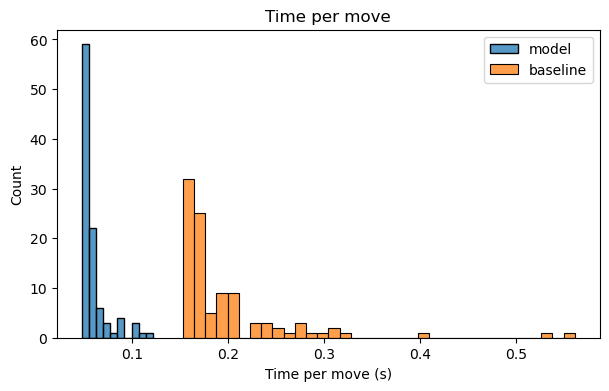

In [49]:
fig = plt.figure(figsize=(7, 4))
sns.histplot(time_per_move_model, label='model', bins=10)
sns.histplot(time_per_move_baseline, label='baseline', bins=35)
plt.legend()
plt.xlabel('Time per move (s)')
plt.ylabel('Count')
plt.title('Time per move - Model & Baseline')
plt.show()

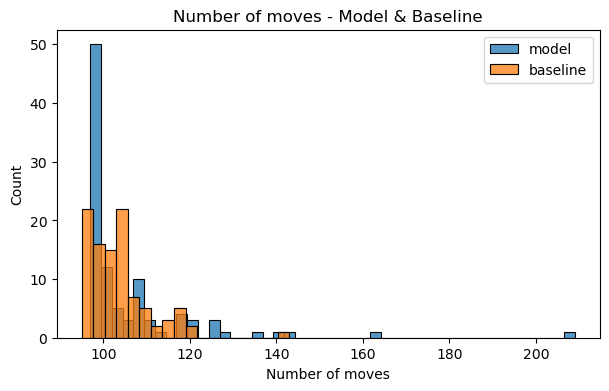

In [54]:
fig = plt.figure(figsize=(7, 4))
sns.histplot(moves_model, label='model', bins=45)
sns.histplot(moves_baseline, label='baseline')
plt.xlabel('Number of moves')
plt.title('Number of moves - Model & Baseline')
plt.legend()